In [80]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#train_data = pd.read_csv("PM.csv")
#df = train_data[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']].rename(columns={'HomeTeam' : 'team1', 'AwayTeam' : 'team2', 'FTHG' : 'score1', 'FTAG' : 'score2'})
#df.to_csv('cleaned_PM.csv')

In [81]:
%run lib/gibbs.py
burn_in = 100
n_samples = 400
alpha = 0.76
beta = -0.12 
draw = True
teams, matches = read_data("data/SerieA.csv", remove_draw=(not draw), sep=',')
sigma_t = 1
match_metrics = []
#random.shuffle(matches)
for idx, m in enumerate(matches):
    team1 = m['team1']
    team2 = m['team2']
    #print(f"Match nr {idx} of {len(matches)}")
    print(f"Match nr {idx} of {len(matches)}\r", end='')
    #print(f"\tteam 1: {team1}\n\tteam 2: {team2}\n\toutcome: {m['outcome']}")
    mu1 = teams[team1]['mean'] 
    mu2 = teams[team2]['mean']
    sig1 = teams[team1]['variance']
    sig2 = teams[team2]['variance']

    #print(teams[team1]['variance'])
    match_metrics.append({'predicted' : predict_game(teams[team1], teams[team2], alpha, beta, draw_possible=draw, sigmat=sigma_t),
                          'true' : m['outcome']})
    s, _ = posterior_gibbs(m['outcome'], variance=(sig1, sig2), mean=(mu1, mu2), diff_variance=sigma_t, samples=n_samples, burn_in=burn_in, t0=1, alpha=alpha, 
                           beta=beta)
    teams[team1]['mean'] = np.mean(s[:,0])
    teams[team1]['variance'] = np.var(s[:,0])
    teams[team2]['mean'] = np.mean(s[:,1])
    teams[team2]['variance'] = np.var(s[:,1])
    #print(teams[team1]['variance'])

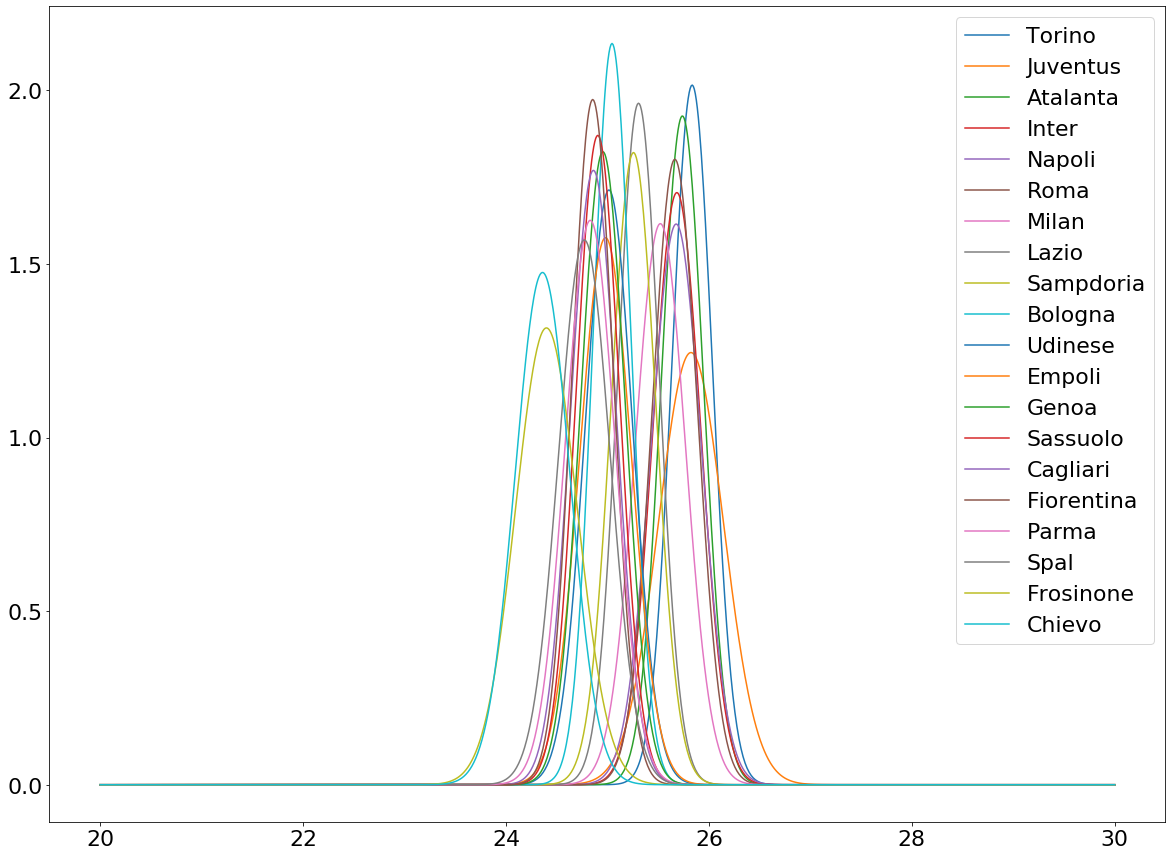

In [82]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,15))
teams = sorted(teams, key=lambda t: -t['mean'])
leg = []
for t in teams:
    leg.append(t['name'])
    plot_team_hist(t)

plt.legend(leg)
plt.show()

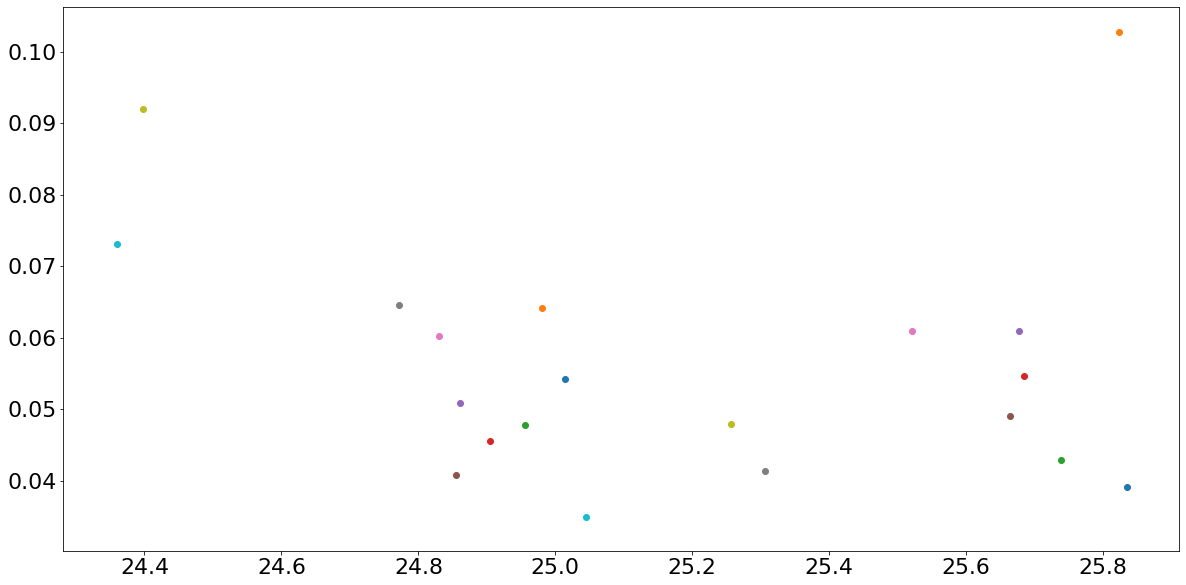

name       mean  variance
0       Torino  25.834707  0.039191
1     Juventus  25.822931  0.102704
2     Atalanta  25.738623  0.042891
3        Inter  25.684134  0.054708
4       Napoli  25.677469  0.061016
5         Roma  25.664525  0.049046
6        Milan  25.521341  0.060931
7        Lazio  25.306432  0.041306
8    Sampdoria  25.256705  0.048005
9      Bologna  25.045049  0.034914
10     Udinese  25.014457  0.054229
11      Empoli  24.980898  0.064112
12       Genoa  24.955182  0.047877
13    Sassuolo  24.904801  0.045500
14    Cagliari  24.861424  0.050823
15  Fiorentina  24.854663  0.040860
16       Parma  24.830141  0.060218
17        Spal  24.772257  0.064635
18   Frosinone  24.398450  0.091929
19      Chievo  24.360003  0.073105

In [83]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for t in teams:
    plt.scatter(t['mean'], t['variance'])
    #plot_team_hist(t)

df = pd.DataFrame(teams)
plt.show()
df

In [84]:
correct = 0
predicted = []
true = []
for idx, m in enumerate(match_metrics):
    if idx < 0:
        continue
    pred = m['predicted']
    if pred == m['true']:
        correct += 1
    predicted.append(pred)
    true.append(m['true'])
    
r = correct / len(match_metrics)
print(f"Prediction accuracy {r}")

Prediction accuracy 0.4631578947368421


[[0.13684211 0.09736842 0.04473684]
 [0.07105263 0.14473684 0.06842105]
 [0.08421053 0.15526316 0.19736842]]


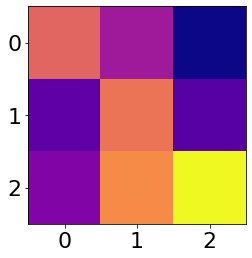

In [70]:
import pandas as pd
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(true, predicted) / len(true)
print(conf)
plt.imshow(conf, cmap='plasma')
plt.show()

In [71]:
%run lib/gibbs.py
mu1 = 25
mu2 = 25
sig1 = 8.3
sig2 = 8.3

s, t = posterior_gibbs(0, variance=(sig1, sig2), mean=(mu1, mu2), diff_variance=1, samples=1000, burn_in=0, t0=2, alpha=0, beta=0)

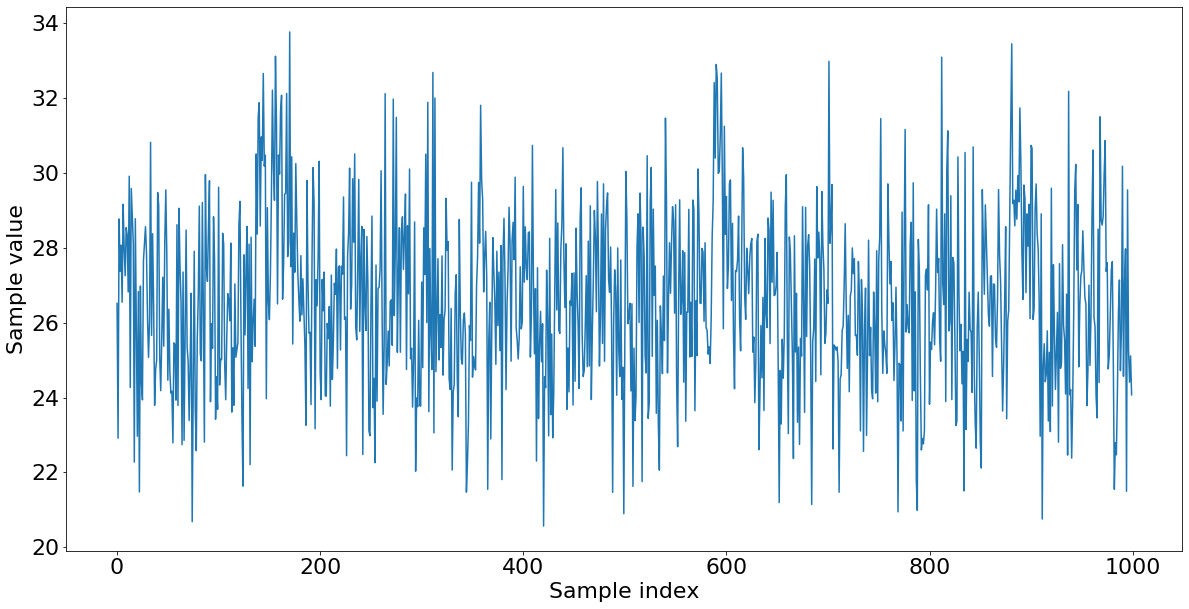

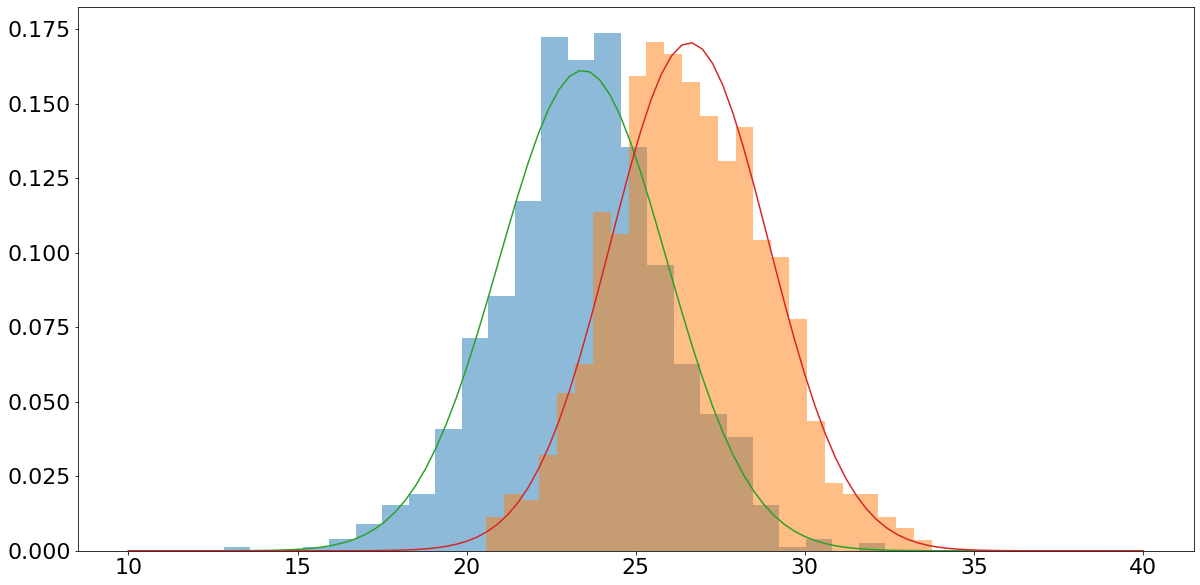

In [72]:
#plt.plot(t)
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(s[:,1])
plt.xlabel('Sample index')
plt.ylabel('Sample value')
#plt.savefig('gibbs_samples.eps')
plt.show()
plt.figure(figsize=(20,10))
plot_with_approx(s)

In [73]:
def sample(n=100):
    mu1 = 25
    mu2 = 25
    sig1 = 8.3
    sig2 = 8.3
    s, t = posterior_gibbs(1, variance=(sig1, sig2), mean=(mu1, mu2), diff_variance=1, samples=n, burn_in=100, t0=1, alpha=0, beta=0)
    return s

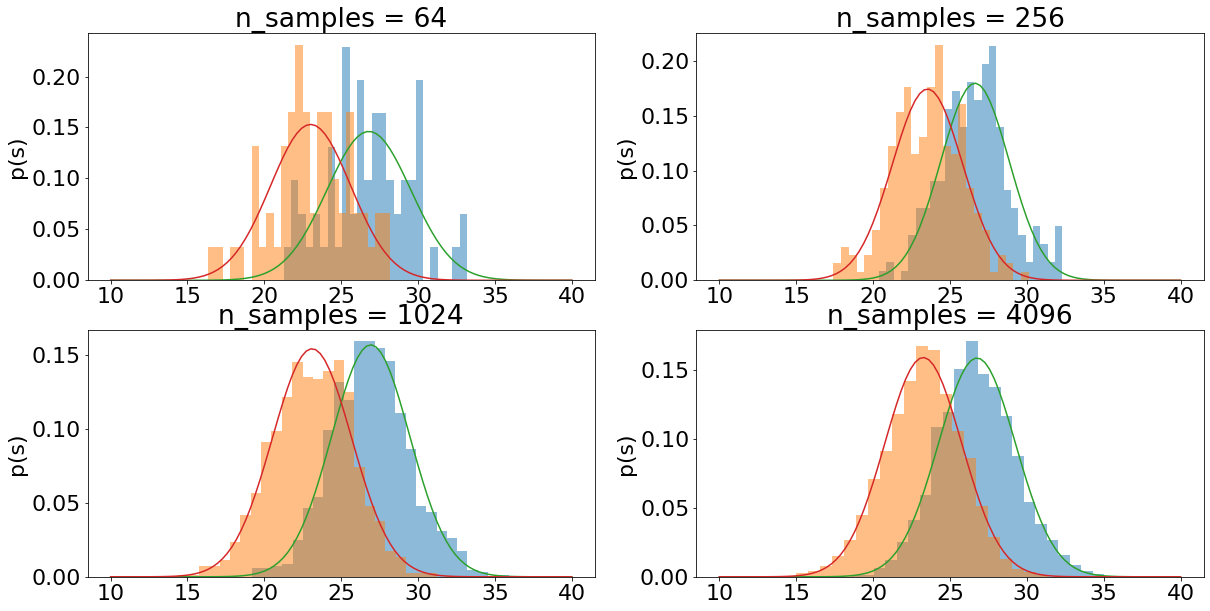

In [85]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.subplot(221)
plot_with_approx(sample(64))
plt.title('n_samples = 64')
plt.ylabel('p(s)')
plt.subplot(222)
plot_with_approx(sample(256))
plt.title('n_samples = 256')
plt.ylabel('p(s)')
plt.subplot(223)
plot_with_approx(sample(1024))
plt.title('n_samples = 1024')
plt.ylabel('p(s)')
plt.subplot(224)
plot_with_approx(sample(4096))
plt.title('n_samples = 4096')
plt.ylabel('p(s)')
plt.savefig('images/gibbs_n_samples.pdf')

## Message Passing

In [162]:
import matplotlib.pyplot as plt
import matplotlib
%run lib/gibbs.py
teams, matches = read_data("data/SerieA.csv", remove_draw=True, sep=',')
print(teams)

[{'name': 'Chievo', 'mean': 25, 'variance': 8.3}, {'name': 'Lazio', 'mean': 25, 'variance': 8.3}, {'name': 'Torino', 'mean': 25, 'variance': 8.3}, {'name': 'Sassuolo', 'mean': 25, 'variance': 8.3}, {'name': 'Parma', 'mean': 25, 'variance': 8.3}, {'name': 'Empoli', 'mean': 25, 'variance': 8.3}, {'name': 'Bologna', 'mean': 25, 'variance': 8.3}, {'name': 'Atalanta', 'mean': 25, 'variance': 8.3}, {'name': 'Juventus', 'mean': 25, 'variance': 8.3}, {'name': 'Napoli', 'mean': 25, 'variance': 8.3}, {'name': 'Spal', 'mean': 25, 'variance': 8.3}, {'name': 'Udinese', 'mean': 25, 'variance': 8.3}, {'name': 'Inter', 'mean': 25, 'variance': 8.3}, {'name': 'Genoa', 'mean': 25, 'variance': 8.3}, {'name': 'Frosinone', 'mean': 25, 'variance': 8.3}, {'name': 'Fiorentina', 'mean': 25, 'variance': 8.3}, {'name': 'Cagliari', 'mean': 25, 'variance': 8.3}, {'name': 'Roma', 'mean': 25, 'variance': 8.3}, {'name': 'Milan', 'mean': 25, 'variance': 8.3}, {'name': 'Sampdoria', 'mean': 25, 'variance': 8.3}]


In [163]:
# go through matches
for match_idx, match in enumerate(matches):
    # get the teams
    s1 = teams[match['team1']]
    s2 = teams[match['team2']]
    
    s1, s2 = posterior_message_passing(match['outcome'], s1, s2, 8.3)
    
    teams[match['team1']]['mean'] = s1['mean']
    teams[match['team1']]['variance'] = s1['variance']
    teams[match['team2']]['mean'] = s2['mean']
    teams[match['team2']]['variance'] = s2['variance']
    
   

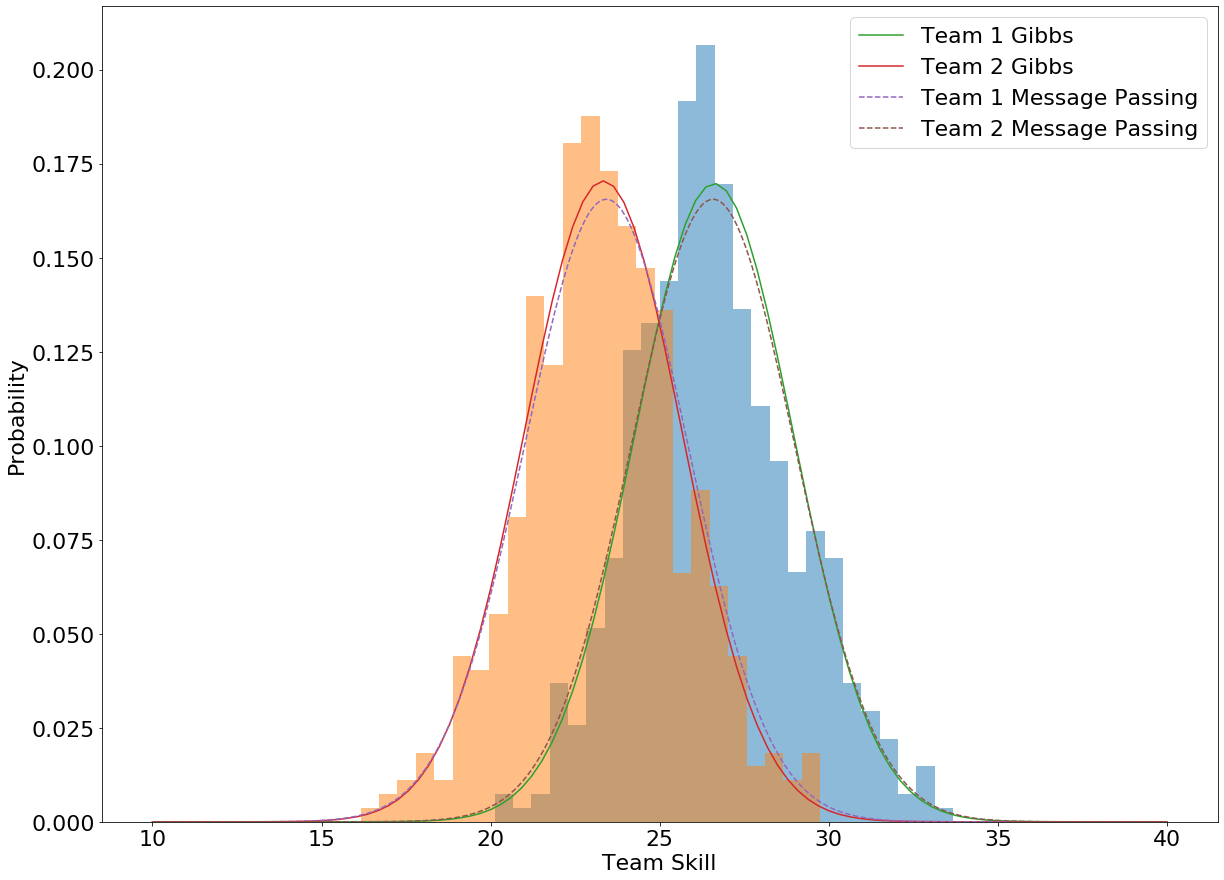

In [164]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,15))
s1 = create_gaussian(25, 8.3)
s2 = create_gaussian(25, 8.3)

s1_mp, s2_mp = posterior_message_passing(1, s1, s2, 1)
ss_gibbs,_ = posterior_gibbs(1, (s1['variance'], s2['variance']), (s1['mean'], s2['mean']), 1, samples=500)
plot_with_approx(ss_gibbs)

plot_team_hist(s1_mp, x0=10, x1=40, dashed=True)
plot_team_hist(s2_mp, x0=10, x1=40, dashed=True)
plt.xlabel('Team Skill')
plt.ylabel('Probability')
plt.legend(['Team 1 Gibbs', 'Team 2 Gibbs', 'Team 1 Message Passing', 'Team 2 Message Passing'])
plt.savefig('images/message_passing_vs_gibbs.pdf')

In [128]:
print(teams)

[{'name': 'Chievo', 'mean': 27.316049346984347, 'variance': 0.5580177662692467}, {'name': 'Lazio', 'mean': 24.374916787060293, 'variance': 0.5144702182125299}, {'name': 'Torino', 'mean': 23.777226244340532, 'variance': 0.6345222829118607}, {'name': 'Sassuolo', 'mean': 25.736764393121003, 'variance': 0.6728633124163792}, {'name': 'Parma', 'mean': 25.76293076475054, 'variance': 0.5773778279585974}, {'name': 'Empoli', 'mean': 25.786742892887442, 'variance': 0.4892002691320061}, {'name': 'Bologna', 'mean': 25.553514417365296, 'variance': 0.5636723497950739}, {'name': 'Atalanta', 'mean': 23.64496355526564, 'variance': 0.5155944656016975}, {'name': 'Juventus', 'mean': 22.880441718262087, 'variance': 0.43392445542579205}, {'name': 'Napoli', 'mean': 23.371567225144727, 'variance': 0.458403662956734}, {'name': 'Spal', 'mean': 25.519972681588587, 'variance': 0.5306741427086741}, {'name': 'Udinese', 'mean': 25.44460236784227, 'variance': 0.5041471004466695}, {'name': 'Inter', 'mean': 23.749336130

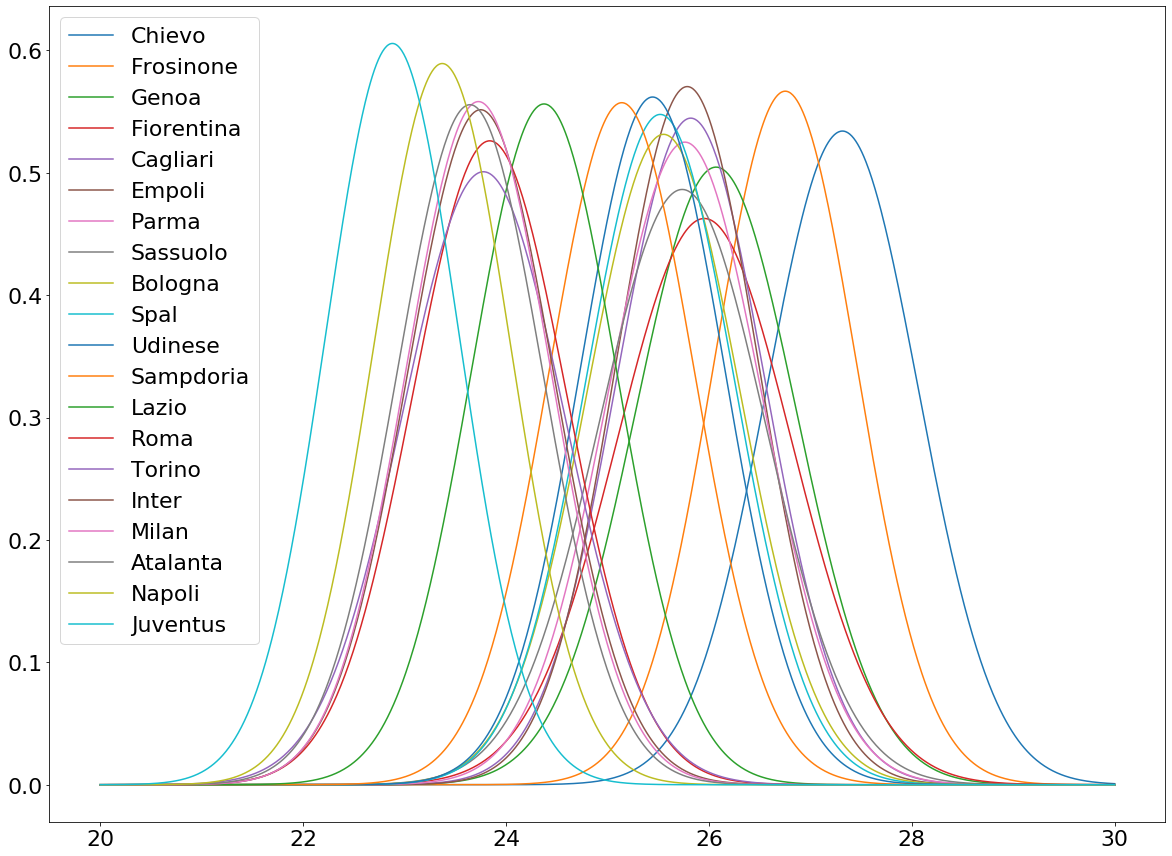

In [129]:

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,15))
teams = sorted(teams, key=lambda t: -t['mean'])
leg = []
for t in teams:
    leg.append(t['name'])
    plot_team_hist(t)

plt.legend(leg)
plt.show()